# Construcción del corpus

In [127]:
SHAKESPEARE_PATH    = '../data/Shakespeare'
JANE_PATH           = '../data/JaneAusten'
LOVECRAFT_PATH      = '../data/Lovecraft'

In [128]:
import re

def normalize(sentence: str) -> str:
    """
    Normalices and returns a sentence.

    Note: Taken and adapeted from P06_word2Vec.ipynb
    class notebook.
    """
    # Step 1: Remove special chars
    sentence = re.sub(r'\W', ' ', str(sentence))
    # Step 2: Remove single characters
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', sentence)
    # Step 3: Remove numbers
    sentence = re.sub(r'[0-9]+', ' ', sentence)
    # Step 4: remove consecutive spaces
    sentence = re.sub(' +', ' ', sentence)
    # Step 5: Sentence to lower cases
    sentence = sentence.lower()

    return sentence

In [129]:
import os

def load_books(path: str) -> str:
    """
    Loads and concatenates all the books in a folder
    path into a single string.
    """
    book_str = ""
    book_paths = os.listdir(path)
    for book_path in book_paths:
        book = open(path + '/' + book_path, 'r', encoding='utf-8')
        lines = book.readlines()
        for sentence in lines:
            book_str += sentence

    return book_str

In [130]:
books = {
    "jane": load_books(JANE_PATH),
    "lovecraft": load_books(LOVECRAFT_PATH),
    "shakespeare": load_books(SHAKESPEARE_PATH),
}

corpus_arr = {"full": []}

for author in books:
    books[author] = normalize(books[author])
    tokenized_book = books[author].split()
    complete_sentences = len(tokenized_book) // 150
    remaining_tokens = len(tokenized_book) % 150
    corpus_arr[author] = []
    for i in range(complete_sentences):
        start = 150 * i
        end = start + 150
        sentence = tokenized_book[start:end]
        corpus_arr[author].append(sentence)
        corpus_arr["full"].append(sentence)
    
    if remaining_tokens > 0:
        start = 150 * complete_sentences
        end = start + remaining_tokens
        sentence = tokenized_book[start:end]
        corpus_arr[author].append(sentence)
        corpus_arr["full"].append(sentence)

['emma',
 'by',
 'jane',
 'austen',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'and',
 'rich',
 'with',
 'comfortable',
 'home',
 'and',
 'happy',
 'disposition',
 'seemed',
 'to',
 'unite',
 'some',
 'of',
 'the',
 'best',
 'blessings',
 'of',
 'existence',
 'and',
 'had',
 'lived',
 'nearly',
 'twenty',
 'one',
 'years',
 'in',
 'the',
 'world',
 'with',
 'very',
 'little',
 'to',
 'distress',
 'or',
 'vex',
 'her',
 'she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'most',
 'affectionate',
 'indulgent',
 'father',
 'and',
 'had',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 'marriage',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'very',
 'early',
 'period',
 'her',
 'mother',
 'had',
 'died',
 'too',
 'long',
 'ago',
 'for',
 'her',
 'to',
 'have',
 'more',
 'than',
 'an',
 'indistinct',
 'remembrance',
 'of',
 'her',
 'caresses',
 'and',
 'her',
 'place',
 'had',
 'been',
 'supplied',
 'by',
 'an',
 'excellent',
 'wo

In [131]:
len(corpus_arr["full"])

5594

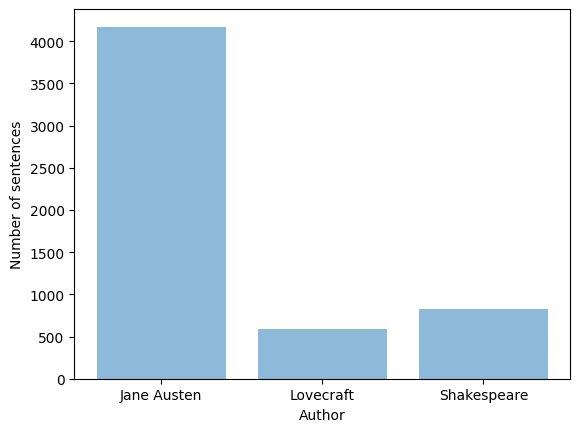

In [181]:
import numpy as np
import matplotlib.pyplot as plt
authors = ("Jane Austen", "Lovecraft", "Shakespeare")
y_pos = np.arange(len(authors))
num_sent = [len(corpus_arr["jane"]), len(corpus_arr["lovecraft"]), len(corpus_arr["shakespeare"])]

plt.bar(y_pos, num_sent, align="center", alpha=0.5)
plt.xticks(y_pos, authors)
plt.ylabel("Number of sentences")
plt.xlabel("Author")

plt.show()

In [132]:
count = 0
tokens = {}
for sentence in corpus_arr["full"]:
    for token in sentence:
        tokens[token] = 1

len(tokens)

24045

# Construcción y visualización de embeddings

In [133]:
EMBEDDING_50_PATH  =    "../models/books_50_l.rojasb_j.arboleda.model"
EMBEDDING_100_PATH =    "../models/books_100_l.rojasb_j.arboleda.model"
EMBEDDING_150_PATH =    "../models/books_150_l.rojasb_j.arboleda.model"

In [134]:
import os
import gensim

def load_embeding(path: str, sentences_arr: list, size: int = None) -> gensim.models.Word2Vec:
    """
    If embeding path exists, loads and returns the embeding.
    If embeding path does not exist, creates, saves and
    returns the embeding. If size is not specified, 50
    will be used by default.
    """    
    if not os.path.exists(path):
        # Give size its default value
        if size is None:
            size = 50
        
        # Train enbeding
        embeding = gensim.models.Word2Vec(sentences_arr, vector_size=size, window=3, min_count=0, workers=10)
        embeding.train(sentences_arr, total_examples=len(sentences_arr), epochs=30)
        embeding.save(path)
        print("Model created and saved")
    else:
        embeding = gensim.models.Word2Vec.load(path)
        print("Model loaded")

    return embeding

In [135]:
embedding_50 = load_embeding(EMBEDDING_50_PATH, corpus_arr["full"], 50)
embedding_100 = load_embeding(EMBEDDING_100_PATH, corpus_arr["full"], 100)
embedding_150 = load_embeding(EMBEDDING_150_PATH, corpus_arr["full"], 150)

Model loaded
Model loaded
Model loaded


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_word_embeddings(model, words_to_visualize, perplexity=30):
    """
    Visualize word embeddings using TSNE in a 2D space
    Params:
    -------
        model: gensim word2vec model
        words_to_visualize: list of words to visualize
    Returns:   
    --------
        None
    """

    similar_words = {search_term: model.wv.most_similar(search_term, topn=5)
                   for search_term in words_to_visualize}
    
    words = sum([[k] + [v[0] for v in similar_words[k]] for k in similar_words.keys()], [])
    word_vectors = np.array([model.wv[word] for word in words])

    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=perplexity)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    labels = words

    plt.figure(figsize=(14, 8))
    plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [137]:
main_characters = [
    "hamlet", "romeo", "juliet", "macbeth", "darcy", "elizabeth",
    "emma", "cthulhu", "dyer", "wilbur"
]
words = ['man', 'queen', 'king', 'queen']

## Visualización

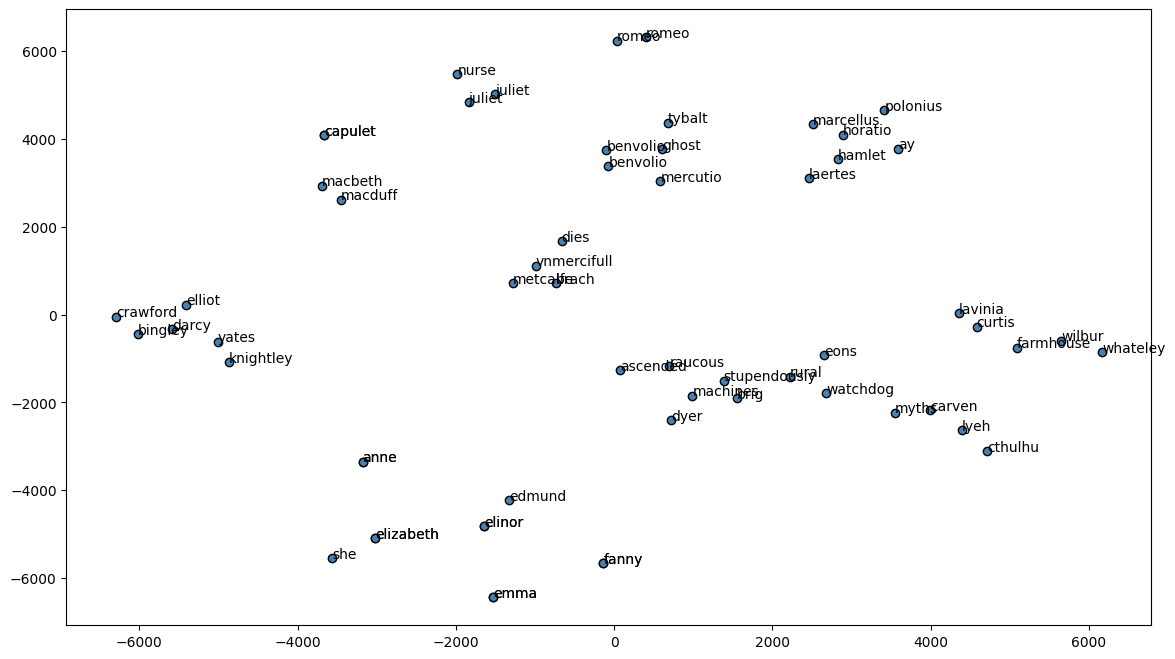

In [138]:
visualize_word_embeddings(embedding_50, main_characters, perplexity=3)

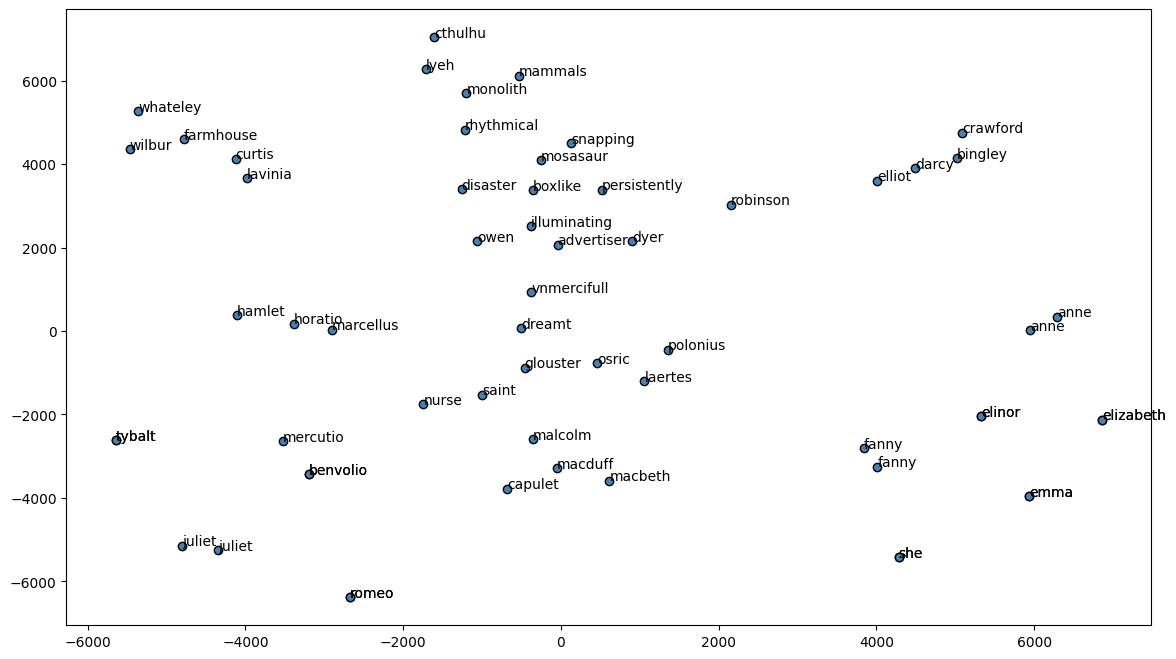

In [139]:
visualize_word_embeddings(embedding_100, main_characters, perplexity=3)

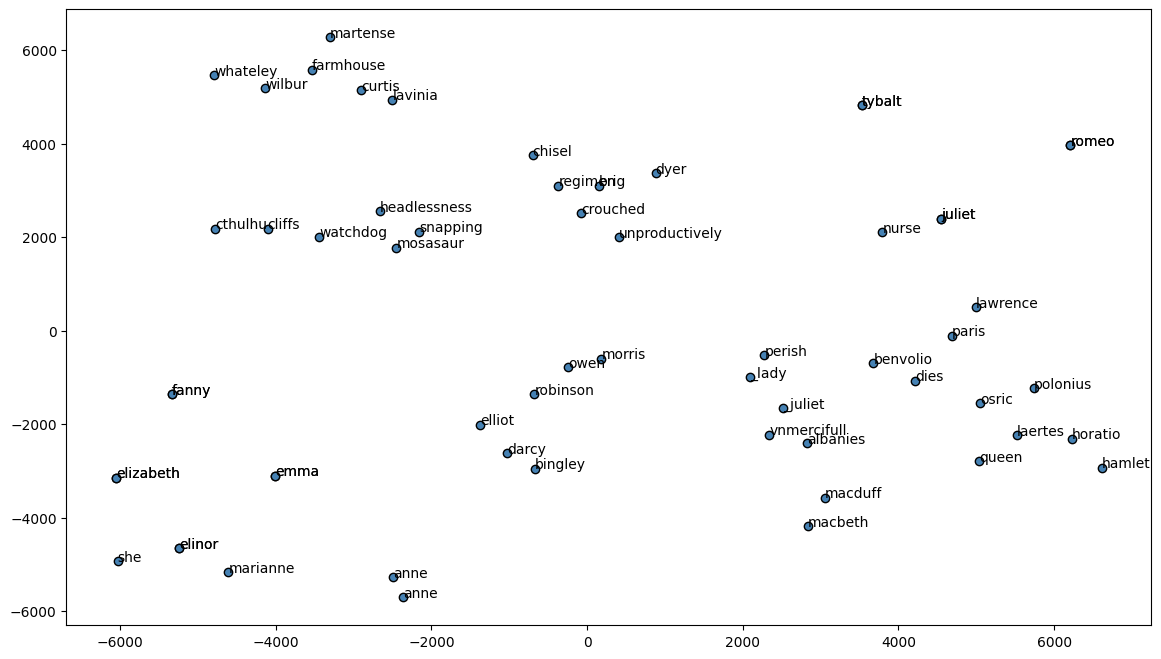

In [140]:
visualize_word_embeddings(embedding_150, main_characters, perplexity=3)

## Relaciones análogas

In [141]:
embedding_50.wv.most_similar('man', topn=5)

[('woman', 0.8905831575393677),
 ('person', 0.7985241413116455),
 ('vntender', 0.6654538512229919),
 ('_man_', 0.6636613607406616),
 ('petruchio', 0.6439080238342285)]

In [142]:
relation = embedding_50.wv['king']-embedding_50.wv['queen']+embedding_50.wv['woman']
embedding_50.wv.most_similar([relation], topn=3)

[('woman', 0.8616428375244141),
 ('man', 0.7869786024093628),
 ('person', 0.7109572291374207)]

In [143]:
relation = embedding_50.wv['good']-embedding_50.wv['bad']+embedding_50.wv['evil']
embedding_50.wv.most_similar([relation], topn=3)

[('good', 0.6650522351264954),
 ('interest', 0.5430381894111633),
 ('joy', 0.5394163131713867)]

In [144]:
relation = embedding_50.wv['woman']-embedding_50.wv['women']+embedding_50.wv['men']
embedding_50.wv.most_similar([relation], topn=3)

[('woman', 0.8592338562011719),
 ('man', 0.8316254615783691),
 ('person', 0.7359143495559692)]

In [145]:
relation = embedding_50.wv['father']-embedding_50.wv['girl']+embedding_50.wv['boy']
embedding_50.wv.most_similar([relation], topn=3)

[('father', 0.7321447730064392),
 ('uncle', 0.6416400671005249),
 ('husband', 0.6039602756500244)]

In [146]:
relation = embedding_50.wv['nurse']-embedding_50.wv['duke']+embedding_50.wv['king']
embedding_50.wv.most_similar([relation], topn=3)

[('nurse', 0.8332308530807495),
 ('king', 0.8263026475906372),
 ('queen', 0.725990355014801)]

In [147]:
relation = embedding_50.wv['king']-embedding_50.wv['crown']+embedding_50.wv['sword']
embedding_50.wv.most_similar([relation], topn=3)

[('king', 0.8274325728416443),
 ('cordelia', 0.7152611017227173),
 ('villaine', 0.7111658453941345)]

In [148]:
relation = embedding_50.wv['sea']-embedding_50.wv['water']+embedding_50.wv['fire']
embedding_50.wv.most_similar([relation], topn=3)

[('fire', 0.7121689915657043),
 ('cart', 0.646477222442627),
 ('sea', 0.615963876247406)]

In [149]:
relation = embedding_50.wv['peace']-embedding_50.wv['war']+embedding_50.wv['love']
embedding_50.wv.most_similar([relation], topn=3)

[('love', 0.864908754825592),
 ('peace', 0.6720847487449646),
 ('heart', 0.6629595160484314)]

In [150]:
relation = embedding_50.wv['death']-embedding_50.wv['life']+embedding_50.wv['eternity']
embedding_50.wv.most_similar([relation], topn=3)

[('woundless', 0.5093585848808289),
 ('vntimely', 0.5062509775161743),
 ('_mr', 0.5058766007423401)]

In [151]:
relation = embedding_50.wv['clear']-embedding_50.wv['day']+embedding_50.wv['night']
embedding_50.wv.most_similar([relation], topn=3)

[('clear', 0.577535092830658),
 ('ripening', 0.5148007273674011),
 ('husban', 0.4983969032764435)]

In [152]:
relation = embedding_50.wv['good']-embedding_50.wv['bad']+embedding_50.wv['hate']
embedding_50.wv.most_similar([relation], topn=3)

[('good', 0.7212997078895569),
 ('hate', 0.5706773996353149),
 ('justice', 0.5641220808029175)]

# Construcción y evaluación de modelos

## 1. Embbeding 50, arquitectura 1

Esta sección muestra el paso a paso de como se construyó el modelo para un embbeding de tamaño 50 y la arquitectura 1

In [153]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_X_Y(corpus_arr: dict, kv: gensim.models.keyedvectors.KeyedVectors):
    """
    Given the corpus array and the keyvectors (kv) of the embedding,
    returns two numpy arrays in the following order:
        X: array of vectors. Each vector represents a sentence
        Y: array of scalars. Each scalar represents the respective
            sentence's author
    """
    x_list = []
    y_list = []
    i = 0
    count = 0
    for author in corpus_arr:
        if author == "full":
            continue

        for sentence in corpus_arr[author]:
            vector = None
            for token in sentence:
                if token in kv:
                    token_vector = kv[token]
                    if vector is None:
                        vector = kv[token]
                    else:
                        vector = np.concatenate((vector, token_vector))
            x_list.append(vector)
            y_list.append(i)
        i += 1

    # Get embedding vector length
    emb_size = len(kv[kv.index_to_key[0]])

    vector_size = 150 * emb_size
    for i in range(len(x_list)):
        vector = x_list[i]
        if len(vector) < vector_size:
            padding = np.zeros((vector_size - len(vector)))
            x_list[i] = np.concatenate((vector, padding))

    X = np.array(x_list)
    Y = np.array(y_list)

    return X,Y

In [154]:
X,Y = get_X_Y(corpus_arr, embedding_50.wv)

In [155]:
X.shape

(5594, 7500)

In [156]:
Y.shape

(5594,)

In [157]:
from sklearn.model_selection import train_test_split
def get_train_test_val(X,Y):
    """
    Returns n-tuple: (X_train, X_test, X_val, y_train, y_test, y_val)
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [158]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(X,Y)

In [159]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential

def get_model(input_size: int, dense_h_layers: list) -> Sequential:
    """
    Generates keras model.
        Params:
        -------
            input_size: int
                Size of input vector
            dense_h_layer: list
                A list of dicts. Each dict represents
                a Dense hidden layer. Each dict should
                have the following keys
                    units: int - number of units of layer
                    activation: str - activation function
                    dropout: float - Dropout ratio

        Returns
        -------
            model: tensorflow.keras.models.Sequential
    """
    model = Sequential()

    model.add(Input(shape=(input_size,)))
    
    for layer in dense_h_layers:
        model.add(Dense(
            layer["units"],
            layer["activation"]
        ))
        if layer["dropout"] > 0:
            model.add(Dropout(layer["dropout"]))
    
    model.add(Dense(3, "softmax"))

    return model

In [160]:
dense_h_layers = [
    {
        "units": 50,
        "activation": "relu",
        "dropout": 0.6
    }
]
model_50 = get_model(X_train.shape[1], dense_h_layers)

In [161]:
model_50.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 50)                375050    
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_38 (Dense)            (None, 3)                 153       
                                                                 
Total params: 375203 (1.43 MB)
Trainable params: 375203 (1.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
model_50.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [163]:
model_50.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=8, verbose=1)

Epoch 1/8
123/123 [==============================] - 3s 13ms/step - loss: 0.2917 - accuracy: 0.9083 - val_loss: 0.0937 - val_accuracy: 0.9643
Epoch 2/8
123/123 [==============================] - 2s 14ms/step - loss: 0.0800 - accuracy: 0.9734 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 3/8
123/123 [==============================] - 2s 14ms/step - loss: 0.0417 - accuracy: 0.9857 - val_loss: 0.0309 - val_accuracy: 0.9929
Epoch 4/8
123/123 [==============================] - 2s 14ms/step - loss: 0.0398 - accuracy: 0.9865 - val_loss: 0.0372 - val_accuracy: 0.9869
Epoch 5/8
123/123 [==============================] - 2s 14ms/step - loss: 0.0328 - accuracy: 0.9888 - val_loss: 0.0413 - val_accuracy: 0.9893
Epoch 6/8
123/123 [==============================] - 2s 15ms/step - loss: 0.0286 - accuracy: 0.9893 - val_loss: 0.0348 - val_accuracy: 0.9917
Epoch 7/8
123/123 [==============================] - 2s 15ms/step - loss: 0.0258 - accuracy: 0.9895 - val_loss: 0.0293 - val_accuracy: 0.9917
Epoch 

In [164]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model_50.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generar un informe de clasificación
report = classification_report(y_test, y_pred)
print("Informe de Clasificación:")
print(report)

27/27 [==============================] - 0s 11ms/step
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       636
           1       0.95      0.97      0.96        89
           2       0.99      0.98      0.99       114

    accuracy                           0.99       839
   macro avg       0.98      0.98      0.98       839
weighted avg       0.99      0.99      0.99       839



## 2. All other architectures

In [165]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def create_train_eval_model(
        kv: gensim.models.keyedvectors.KeyedVectors,
        dense_h_layers: list,
        corpus_arr: dict,
        epochs: int,
        name: str = "Model",
        verbose = 0
        ):
    """
    Creates and trains the embedding with all the books.
    Creates and trains the FeedForeward neural network
    Evaluates the neural network and prints results.
    
        Params
        ------
            embedding: gensim.models.Word2Vec
                Embedding
            dense_h_layer: list
                A list of dicts. Each dict represents
                a Dense hidden layer. Each dict should
                have the following keys
                    units: int - number of units of layer
                    activation: str - activation function
                    dropout: float - Dropout ratio
            corpus_arr: list
            epochs: int
                Number of epochs
            name: str
                Architechture name. Default vlaue is "model"
    """
    print("===========", name, "===========")
    x,y = get_X_Y(corpus_arr, kv)
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(x,y)
    model = get_model(X_train.shape[1], dense_h_layers)
    # print(model.summary())
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=epochs, verbose=verbose)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_pred)
    print(report)

In [166]:
architectures = [
    {
        "name": "arch1",
        "dense_h_layers": [
            {
                "units": 10,
                "activation": "relu",
                "dropout": 0.6
            }
        ],
        "epochs": 8
    },
    {
        "name": "arch2",
        "dense_h_layers": [
            {
                "units": 50,
                "activation": "relu",
                "dropout": 0.6
            },
        ],
        "epochs": 8
    },
    {
        "name": "arch3",
        "dense_h_layers": [
            {
                "units": 3,
                "activation": "relu",
                "dropout": 0.6
            },
            {
                "units": 3,
                "activation": "relu",
                "dropout": 0.6
            }
        ],
        "epochs": 50
    },
]

In [167]:
embeddings = [
    {
        "size": 50,
        "path": EMBEDDING_50_PATH
    },
    {
        "size": 100,
        "path": EMBEDDING_100_PATH
    },
    {
        "size": 150,
        "path": EMBEDDING_150_PATH
    },
]

In [168]:
for emb_desc in embeddings:
    embedding = load_embeding(emb_desc["path"], corpus_arr["full"], emb_desc["size"])
    for architecture in architectures:
        create_train_eval_model(
            embedding.wv,
            architecture["dense_h_layers"],
            corpus_arr,
            architecture["epochs"],
            architecture["name"] + " - " + str(emb_desc["size"])
        )

Model loaded
=========== arch1 - 50 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       631
           1       0.96      0.94      0.95        93
           2       0.97      0.99      0.98       115

    accuracy                           0.99       839
   macro avg       0.97      0.97      0.97       839
weighted avg       0.99      0.99      0.99       839

=========== arch2 - 50 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       624
           1       0.96      0.92      0.94        78
           2       0.99      0.98      0.99       137

    accuracy                           0.99       839
   macro avg       0.98      0.97      0.97       839
weighted avg       0.99      0.99      0.99       839

=========== arch3 - 50 ===========
27/27 [=======

c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model loaded
=========== arch1 - 100 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       617
           1       0.00      0.00      0.00       100
           2       0.99      0.93      0.96       122

    accuracy                           0.87       839
   macro avg       0.61      0.64      0.63       839
weighted avg       0.77      0.87      0.81       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=========== arch2 - 100 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       654
           1       0.94      0.93      0.94        70
           2       0.98      0.97      0.98       115

    accuracy                           0.99       839
   macro avg       0.97      0.97      0.97       839
weighted avg       0.99      0.99      0.99       839

=========== arch3 - 100 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       616
           1       0.96      0.87      0.92        94
           2       0.00      0.00      0.00       129

    accuracy                           0.83       839
   macro avg       0.59      0.62      0.60       839
weighted avg       0.70      0.83      0.76       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model loaded
=========== arch1 - 150 ===========
27/27 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       636
           1       0.99      0.81      0.89        83
           2       1.00      0.95      0.97       120

    accuracy                           0.97       839
   macro avg       0.98      0.92      0.95       839
weighted avg       0.97      0.97      0.97       839

=========== arch2 - 150 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       626
           1       0.93      0.94      0.93        83
           2       0.99      0.97      0.98       130

    accuracy                           0.98       839
   macro avg       0.97      0.97      0.97       839
weighted avg       0.98      0.98      0.98       839

=========== arch3 - 150 ===========
27/27 [====

c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
import gensim.downloader
embeddings = [
    {    
        "size": 50,
        "name": "glove-wiki-gigaword-50"
    },
    {    
        "size": 100,
        "name": "glove-wiki-gigaword-100"
    },
    {    
        "size": 200,
        "name": "glove-wiki-gigaword-200"
    }
]

In [173]:
architectures[0]["epochs"] = 7

In [174]:
for emb_desc in embeddings:
    embedding = gensim.downloader.load(emb_desc["name"])
    for architecture in architectures:
        create_train_eval_model(
            embedding,
            architecture["dense_h_layers"],
            corpus_arr,
            architecture["epochs"],
            architecture["name"] + " - " + str(emb_desc["size"])
        )

=========== arch1 - 50 ===========
27/27 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       615
           1       0.00      0.00      0.00        97
           2       0.00      0.00      0.00       127

    accuracy                           0.73       839
   macro avg       0.24      0.33      0.28       839
weighted avg       0.54      0.73      0.62       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=========== arch2 - 50 ===========
27/27 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       612
           1       0.92      0.87      0.89        90
           2       0.94      0.91      0.92       137

    accuracy                           0.96       839
   macro avg       0.94      0.92      0.93       839
weighted avg       0.96      0.96      0.96       839

=========== arch3 - 50 ===========
27/27 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       621
           1       0.00      0.00      0.00        91
           2       1.00      0.51      0.68       127

    accuracy                           0.82       839
   macro avg       0.60      0.50      0.52       839
weighted avg       0.75      0.82      0.76       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=========== arch1 - 100 ===========
27/27 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       630
           1       0.00      0.00      0.00        80
           2       0.00      0.00      0.00       129

    accuracy                           0.75       839
   macro avg       0.25      0.33      0.29       839
weighted avg       0.56      0.75      0.64       839


c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 arch2 - 100 ===========
27/27 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       611
           1       0.90      0.64      0.75       102
           2       0.97      0.85      0.91       126

    accuracy                           0.93       839
   macro avg       0.93      0.83      0.87       839
weighted avg       0.93      0.93      0.93       839

=========== arch3 - 100 ===========
27/27 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       608
           1       0.00      0.00      0.00        93
           2       0.00      0.00      0.00       138

    accuracy                           0.72       839
   macro avg       0.24      0.33      0.28       839
weighted avg       0.53      0.72      0.61       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[==================================================] 100.0% 252.1/252.1MB downloaded
=========== arch1 - 200 ===========
27/27 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       611
           1       0.00      0.00      0.00        87
           2       0.99      0.70      0.82       141

    accuracy                           0.85       839
   macro avg       0.61      0.57      0.58       839
weighted avg       0.77      0.85      0.80       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=========== arch2 - 200 ===========
27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       628
           1       0.93      0.77      0.84        90
           2       0.95      0.87      0.91       121

    accuracy                           0.95       839
   macro avg       0.95      0.88      0.91       839
weighted avg       0.95      0.95      0.95       839

=========== arch3 - 200 ===========
27/27 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       627
           1       0.00      0.00      0.00        97
           2       0.00      0.00      0.00       115

    accuracy                           0.75       839
   macro avg       0.25      0.33      0.29       839
weighted avg       0.56      0.75      0.64       839



c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanc\anaconda3\envs\nlpEnv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
